In [25]:
from __future__ import division
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

### 1. Download the dataset(s) for your project. If a train set and a test set are not already available, randomly split the dataset into a train and a test set using stratified sampling so that 80% of the samples go to train set and 20% to test set.

Data was retrieved from: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [9]:
data = pd.read_csv("datatraining.csv")

y = data['Occupancy']
X = data.loc[:, data.columns != 'Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

### 2. Randomly split your train set into a validation and a new train set (called train set 2) such that the validation set contains 1/5 of the samples in original train set and the train set 2 contains the remaining. Use stratified sampling to assign features to train set 2 and validation set. This should ensure that your validation set contains samples from both classes (i.e. ciliary and non-ciliary with equal proportions)

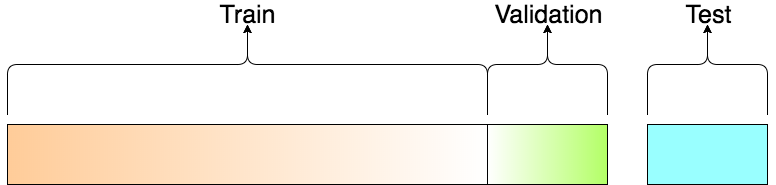

In [10]:
X_train_two, X_validation, y_train_two, y_validation = train_test_split(X_train, y_train, test_size=0.20, 
                                                                        stratify=y_train,random_state=42)

### 3. Normalize features in your train set 2 and validation set using min-max scaling to interval [0,1]. For this purpose you can first normalize features in your train set 2 and use the same scaling coefficients to normalize validation set. Save the normalized versions as separate files. Repeat normalizing your original train set and use the same normalization coefficients to normalize the two test sets.

In [11]:
scaler = MinMaxScaler()

scaler.fit(X_train_two)
normalized_x_train_two = scaler.transform(X_train_two)
normalized_x_validation = scaler.transform(X_validation)

np.savetxt("normalized_x_train_two.csv", normalized_x_train_two, delimiter=",")
np.savetxt("normalized_x_validation.csv", normalized_x_validation, delimiter=",")

scaler.fit(normalized_x_train_two)
normalized_x_train = scaler.transform(X_train)
normalized_x_test = scaler.transform(X_test)
normalized_x_validation_with_orig = scaler.transform(X_validation)

### 4. Perform a 10-fold cross-validation experiment for the random forest classifier on normalized and unnormalized versions of train set 2. You can set the number of trees to 100. Do you get better accuracy when you perform data normalization?

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_two, y_train_two)

unnormalized_accuracy = clf.score(X_validation, y_validation)

clf.fit(normalized_x_train_two, y_train_two)
normalized_accuracy = clf.score(normalized_x_validation, y_validation)

if unnormalized_accuracy > normalized_accuracy or unnormalized_accuracy == normalized_accuracy:
    print("No, I did not. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))
else:
    print("Yes, I did. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))

Yes, I did. Unnormalized Accuracy: 0.992325402916, Normalized Accuracy: 0.993092862625


### 5. Perform a 10-fold cross-validation experiment on train set 2 that corresponds to the best performing normalization strategy (i.e. normalized or unnormalized) for the following classifiers: 

Logistic regression

k-nearest neighbor (with k=1)

Naïve Bayes

Decision tree

Random forest (number of trees=100)

SVM (RBF kernel C=1.0 gamma=0.125)

RBF network (number of clusters = 3)

Adaboost (number of iterations=10)

You can use default values for other hyper-parameters of the classifiers
Report the following accuracy measures for each of these classifiers: overall
accuracy, F-measure, sensitivity, specificity, precision, area under the ROC curve,
area under the precision recall curve, MCC scores. These will be cross-validation
accuracies.

In [26]:
models = [
    ("Logistic Regression",LogisticRegression(random_state=42)),
    ("K-Nearest Neighbour",KNeighborsClassifier(n_neighbors=1)),
    ("Naive Bayes",GaussianNB()),
    ("Decision Tree",DecisionTreeClassifier(random_state=42)),
    ("Random Forest",RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Support Vector Machine",SVC(kernel="rbf", C=1,gamma=0.125, random_state=42)),
    #("RBF Network", RBFNetwork()),
    ("AdaBoostClassifier",AdaBoostClassifier(n_estimators=10, random_state=42))
]

metrics = [
    ("Accuracy Score", accuracy_score),
    ("F-Measure", f1_score),
    ("Sensitivity", recall_score),
    #("Specificity", recall_score),
    ("Precision", precision_score),
    ("Area Under ROC Curve", roc_auc_score),
    #("Area Under Precision Recall Curve", precision_recall_curve),
    ("MCC", matthews_corrcoef)
]

def dump_metrics(features, label, name, model):
    accuracy = 0.0
    
    for metric_name, metric in metrics:
        kfold = StratifiedKFold(n_splits=10, random_state=42)
        scorer = make_scorer(metric)

        cv_result = cross_val_score(model,features,label.values.ravel(), cv = kfold,scoring = scorer)
        
        if metric_name == "Accuracy Score":
            accuracy = cv_result

        print("{} {}: {}".format(name, metric_name, cv_result.mean()))
    print("")
    
    return accuracy.mean()

print("Unnormalized Results:\n")
for name,model in models:
    dump_metrics(X_train_two, y_train_two, name, model)

print("\nNormalized Results:\n")
for name,model in models:
    dump_metrics(normalized_x_train_two, y_train_two, name, model)

Unnormalized Results:

Logistic Regression Accuracy Score: 0.989446660535
Logistic Regression F-Measure: 0.975721875446
Logistic Regression Sensitivity: 0.996388206388
Logistic Regression Precision: 0.956013545276
Logistic Regression Area Under ROC Curve: 0.991982008956
Logistic Regression MCC: 0.969373266364

K-Nearest Neighbour Accuracy Score: 0.99059755803
K-Nearest Neighbour F-Measure: 0.977859330471
K-Nearest Neighbour Sensitivity: 0.978296478296
K-Nearest Neighbour Precision: 0.977764810606
K-Nearest Neighbour Area Under ROC Curve: 0.986102722562
K-Nearest Neighbour MCC: 0.972029310625

Naive Bayes Accuracy Score: 0.977166969876
Naive Bayes F-Measure: 0.948884333148
Naive Bayes Sensitivity: 0.996388206388
Naive Bayes Precision: 0.905878297015
Naive Bayes Area Under ROC Curve: 0.984187812766
Naive Bayes MCC: 0.936065975649

Decision Tree Accuracy Score: 0.991366790213
Decision Tree F-Measure: 0.979733150444
Decision Tree Sensitivity: 0.980122850123
Decision Tree Precision: 0.97953

### 6. Use three feature selection methods to select feature subsets on train set 2 and compute accuracy measures in step 5 for all the classifiers. Repeat for normalized version of train set 2. Do you get improvement in accuracy when you perform feature selection or is it better to use all of the features? Which feature selection strategy gives the best accuracy?

In [14]:
selectors = [
    ("VarianceThreshold Selector1", VarianceThreshold(threshold=0.1)), # First selector. Threshold was optimized beforehand.
    ("SelectKBest", SelectKBest(f_classif,k=2)), # second selector. k was optimized beforehand
    ("SelectKBest", SelectKBest(chi2,k=2)) # third selector. k was optimized beforehand
]

for selector_name,selector in selectors:    
    selected_x_train_two = selector.fit_transform(X_train_two, y=y_train_two)
    selected_normalized_x_train_two  = scaler.fit_transform(selected_x_train_two)
    
    print("{} unnormalized results:\n".format(selector_name))
    for name, model in models:
        dump_metrics(selected_x_train_two, y_train_two, name, model)

    print("{} normalized results:\n".format(selector_name))
    for name, model in models:
        dump_metrics(selected_normalized_x_train_two, y_train_two, name, model)

print("While it is possible get improvement for some models such as Naive Bayes, it is better to use all of the features for the most accurate model which is K-Nearest Neighbour.")

VarianceThreshold Selector1 unnormalized results:

Logistic Regression Accuracy Score: 0.989444848913
Logistic Regression F-Measure: 0.975770610521
Logistic Regression Sensitivity: 0.996503730022
Logistic Regression Precision: 0.956043827593
Logistic Regression Area Under ROC Curve: 0.99203463113
Logistic Regression MCC: 0.969429757352

K-Nearest Neighbour Accuracy Score: 0.990597215787
K-Nearest Neighbour F-Measure: 0.977935073672
K-Nearest Neighbour Sensitivity: 0.978283772337
K-Nearest Neighbour Precision: 0.977935585656
K-Nearest Neighbour Area Under ROC Curve: 0.986085917877
K-Nearest Neighbour MCC: 0.972097052435

Naive Bayes Accuracy Score: 0.977164456799
Naive Bayes F-Measure: 0.948870002332
Naive Bayes Sensitivity: 0.996503730022
Naive Bayes Precision: 0.905800044975
Naive Bayes Area Under ROC Curve: 0.984238121356
Naive Bayes MCC: 0.936060931094

Decision Tree Accuracy Score: 0.991748847265
Decision Tree F-Measure: 0.978087660081
Decision Tree Sensitivity: 0.980009622091
Deci

K-Nearest Neighbour Sensitivity: 0.972994900796
K-Nearest Neighbour Precision: 0.97599234349
K-Nearest Neighbour Area Under ROC Curve: 0.983197815654
K-Nearest Neighbour MCC: 0.967505439107

Naive Bayes Accuracy Score: 0.980810554416
Naive Bayes F-Measure: 0.956691961578
Naive Bayes Sensitivity: 0.996503730022
Naive Bayes Precision: 0.920231419054
Naive Bayes Area Under ROC Curve: 0.986557412478
Naive Bayes MCC: 0.945746474869

Decision Tree Accuracy Score: 0.986375302432
Decision Tree F-Measure: 0.96789416456
Decision Tree Sensitivity: 0.965417570193
Decision Tree Precision: 0.971462395911
Decision Tree Area Under ROC Curve: 0.97999113708
Decision Tree MCC: 0.962766670032

Random Forest Accuracy Score: 0.990213706327
Random Forest F-Measure: 0.977148880705
Random Forest Sensitivity: 0.985522679049
Random Forest Precision: 0.96905196115
Random Forest Area Under ROC Curve: 0.98849534906
Random Forest MCC: 0.971029261754

Support Vector Machine Accuracy Score: 0.95144836411
Support Vecto

### 7. Choose the version of train set 2 that contains the optimum feature set you found in step 6 and the data for the best normalization strategy. Optimize the following hyperparameters:

k parameter in k-NN
number of trees in random forest
Number of clusters in RBF network
Number of iterations in Adaboost
C, gamma parameter in SVM

Try a grid of values and choose the best value(s) that maximize the overall cross validation accuracy.

•For k-NN you can choose 1 5 10 15 ... 100 (with increments of 5 after k=5)
•For number of trees in random forest you can try 5 10 25 50 75 100 150 200 250 300 350 400 450 500
•For number of clusters in RBF network you can try: 2 3 4 5 6 7 8 9 10 15 20 25 30 35 40 45 50
•For the number of iterations in Adaboost you can try 5 10 15 20 25 30 40 50 75 100 125 150 175 200

To optimize C and gamma parameters of the SVM you can consider the
following parameter grid:

C ∈ {2^-5, 2^-3, 2^-1, 2^1, 2^3, 2^5, ... 2^13, 2^15}
γ ∈ {2^-15, 2^-13, ... , 2^-1, 2^1, 2^3, 2^5}

There are a total of 11 values for the C parameter and 11 values for the gamma parameter (a total of 121 values to consider for the (C, gamma) pair).

Report the best cross-validation accuracies and optimum parameter values you found.

Compute predictions on the validation set using the models trained by optimum
hyper-parameters. Report the same accuracy measures as in step 5.

In [15]:
name, selector = selectors[0]

optimum_x_train_two = selector.fit_transform(X_train_two, y=y_train_two)
optimum_normalized_x_train_two  = scaler.fit_transform(optimum_x_train_two)

hyper_parameters = {
    "K-Nearest Neighbour": [1] + [i*5 for i in range(1,21)],
    "Random Forest": [5,10,25,50,75,100,150,200,250,300,350,400,450,500],
    #"RBF Network": [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]),
    "AdaBoostClassifier": [5,10,15,20,25,30,40,50,75,100,125,150,175,200],
    "Support Vector Machine": ([2**i for i in range(-5,16,2)], [2**i for i in range(-15,6,2)])
}

opt_param_k_nearest,opt_param_random_forest,opt_param_svm,opt_param_ada = 0,0,0,0

for model_name, parameters in hyper_parameters.iteritems():
    model = None
    optimum_accuracy = 0.0
    optimum_parameters = ""
    
    if model_name == "K-Nearest Neighbour":
        for parameter in parameters:
            print("n_neighbors: {}".format(parameter))
            model = KNeighborsClassifier(n_neighbors=parameter)
            accuracy = dump_metrics(optimum_normalized_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_neighbors=" + str(parameter)
    elif model_name == "Random Forest":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = RandomForestClassifier(n_estimators=parameter)
            accuracy = dump_metrics(optimum_normalized_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
    elif model_name == "Support Vector Machine":
        C_values = parameters[0]
        gamma_values = parameters[1]
        
        for C in C_values:
            for gamma in gamma_values:
                print("C: {}, gamma: {}".format(C, gamma))
                model = SVC(kernel="rbf", C=C,gamma=gamma)
                accuracy = dump_metrics(optimum_normalized_x_train_two, y_train_two, model_name, model)
                
                if accuracy > optimum_accuracy:
                    optimum_accuracy = accuracy
                    optimum_parameters = "C:" + str(C) + ", " + "gamma:" + str(gamma)
    elif model_name == "AdaBoostClassifier":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = AdaBoostClassifier(n_estimators=parameter)
            accuracy = dump_metrics(optimum_normalized_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
    
    print("Optimum Accuracy for {}: {}".format(model_name, optimum_accuracy))
    print("Optimum Parameters:")
    print(optimum_parameters + "\n\n")

n_estimators: 5
AdaBoostClassifier Accuracy Score: 0.988869033174
AdaBoostClassifier F-Measure: 0.974168295796
AdaBoostClassifier Sensitivity: 0.987554728543
AdaBoostClassifier Precision: 0.961279917036
AdaBoostClassifier Area Under ROC Curve: 0.988421446682
AdaBoostClassifier MCC: 0.967270189066

n_estimators: 10
AdaBoostClassifier Accuracy Score: 0.989637155191
AdaBoostClassifier F-Measure: 0.976070402469
AdaBoostClassifier Sensitivity: 0.989271498364
AdaBoostClassifier Precision: 0.963399737458
AdaBoostClassifier Area Under ROC Curve: 0.989512890258
AdaBoostClassifier MCC: 0.969669060856

n_estimators: 15
AdaBoostClassifier Accuracy Score: 0.989828726072
AdaBoostClassifier F-Measure: 0.976393169621
AdaBoostClassifier Sensitivity: 0.985684120989
AdaBoostClassifier Precision: 0.967568482574
AdaBoostClassifier Area Under ROC Curve: 0.988331953002
AdaBoostClassifier MCC: 0.970096102722

n_estimators: 20
AdaBoostClassifier Accuracy Score: 0.990788786669
AdaBoostClassifier F-Measure: 0.97

/home/muhammet/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0


/home/muhammet/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5


/home/muhammet/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.0001220703125
Support Vector Machine Accuracy Score: 0.787757113126
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.00048828125
Support Vector Machine Accuracy Score: 0.787757113126
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.001953125
Support Vector Machine Accuracy Score: 0.787757113126
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.0078125
Support Vector Machine Accuracy Score: 0.787757113126
Support Vector Machine F-Meas

Support Vector Machine MCC: 0.950627899891

C: 0.5, gamma: 0.125
Support Vector Machine Accuracy Score: 0.989636787492
Support Vector Machine F-Measure: 0.976198976308
Support Vector Machine Sensitivity: 0.998275862069
Support Vector Machine Precision: 0.955236201503
Support Vector Machine Area Under ROC Curve: 0.992800215226
Support Vector Machine MCC: 0.970026195211

C: 0.5, gamma: 0.5
Support Vector Machine Accuracy Score: 0.989252910333
Support Vector Machine F-Measure: 0.975309776601
Support Vector Machine Sensitivity: 0.997421161214
Support Vector Machine Precision: 0.954344362693
Support Vector Machine Area Under ROC Curve: 0.99225381718
Support Vector Machine MCC: 0.968904111115

C: 0.5, gamma: 2
Support Vector Machine Accuracy Score: 0.989828726072
Support Vector Machine F-Measure: 0.976659745706
Support Vector Machine Sensitivity: 0.998275862069
Support Vector Machine Precision: 0.956136643229
Support Vector Machine Area Under ROC Curve: 0.992920697154
Support Vector Machine 

Support Vector Machine MCC: 0.970428833546

C: 8, gamma: 32
Support Vector Machine Accuracy Score: 0.993667129967
Support Vector Machine F-Measure: 0.985177038201
Support Vector Machine Sensitivity: 0.990809730602
Support Vector Machine Precision: 0.979692525826
Support Vector Machine Area Under ROC Curve: 0.992596794875
Support Vector Machine MCC: 0.981207877079

C: 32, gamma: 3.0517578125e-05
Support Vector Machine Accuracy Score: 0.787757113126
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine MCC: 0.0

C: 32, gamma: 0.0001220703125
Support Vector Machine Accuracy Score: 0.903664482538
Support Vector Machine F-Measure: 0.721328339139
Support Vector Machine Sensitivity: 0.590066227601
Support Vector Machine Precision: 0.931649422239
Support Vector Machine Area Under ROC Curve: 0.789177684785
Support Vector Machine MCC: 0.692879332674

C: 32, gamma:

Support Vector Machine MCC: 0.970026195211

C: 512, gamma: 0.00048828125
Support Vector Machine Accuracy Score: 0.987910075672
Support Vector Machine F-Measure: 0.972285347802
Support Vector Machine Sensitivity: 0.994818902362
Support Vector Machine Precision: 0.9508792084
Support Vector Machine Area Under ROC Curve: 0.990463613291
Support Vector Machine MCC: 0.965007072237

C: 512, gamma: 0.001953125
Support Vector Machine Accuracy Score: 0.987142321354
Support Vector Machine F-Measure: 0.970402938159
Support Vector Machine Sensitivity: 0.98682021144
Support Vector Machine Precision: 0.954654099522
Support Vector Machine Area Under ROC Curve: 0.987072389912
Support Vector Machine MCC: 0.962454748078

C: 512, gamma: 0.0078125
Support Vector Machine Accuracy Score: 0.987142321354
Support Vector Machine F-Measure: 0.970402938159
Support Vector Machine Sensitivity: 0.98682021144
Support Vector Machine Precision: 0.954654099522
Support Vector Machine Area Under ROC Curve: 0.987072389912
Su

Support Vector Machine Area Under ROC Curve: 0.986734156243
Support Vector Machine MCC: 0.962422221328

C: 8192, gamma: 0.03125
Support Vector Machine Accuracy Score: 0.989636787492
Support Vector Machine F-Measure: 0.976199568715
Support Vector Machine Sensitivity: 0.997358430876
Support Vector Machine Precision: 0.956077698342
Support Vector Machine Area Under ROC Curve: 0.992461981558
Support Vector Machine MCC: 0.969995306524

C: 8192, gamma: 0.125
Support Vector Machine Accuracy Score: 0.989444848913
Support Vector Machine F-Measure: 0.975788190775
Support Vector Machine Sensitivity: 0.997358430876
Support Vector Machine Precision: 0.95528512281
Support Vector Machine Area Under ROC Curve: 0.992338219182
Support Vector Machine MCC: 0.969471596013

C: 8192, gamma: 0.5
Support Vector Machine Accuracy Score: 0.990020664652
Support Vector Machine F-Measure: 0.977024822196
Support Vector Machine Sensitivity: 0.998203351595
Support Vector Machine Precision: 0.956875226309
Support Vector

K-Nearest Neighbour MCC: 0.96763602777

n_neighbors: 40
K-Nearest Neighbour Accuracy Score: 0.988869768571
K-Nearest Neighbour F-Measure: 0.974322872343
K-Nearest Neighbour Sensitivity: 0.990118297669
K-Nearest Neighbour Precision: 0.959371851908
K-Nearest Neighbour Area Under ROC Curve: 0.989327072268
K-Nearest Neighbour MCC: 0.967556331542

n_neighbors: 45
K-Nearest Neighbour Accuracy Score: 0.98925364573
K-Nearest Neighbour F-Measure: 0.975282868047
K-Nearest Neighbour Sensitivity: 0.994687227559
K-Nearest Neighbour Precision: 0.956842017997
K-Nearest Neighbour Area Under ROC Curve: 0.991248331118
K-Nearest Neighbour MCC: 0.968806075653

n_neighbors: 50
K-Nearest Neighbour Accuracy Score: 0.988102014252
K-Nearest Neighbour F-Measure: 0.972419935277
K-Nearest Neighbour Sensitivity: 0.990057281805
K-Nearest Neighbour Precision: 0.955594520679
K-Nearest Neighbour Area Under ROC Curve: 0.98881645202
K-Nearest Neighbour MCC: 0.965160103153

n_neighbors: 55
K-Nearest Neighbour Accuracy Sc

### 8. Implement a stacking ensemble, which combines the best performing classifiers obtained in step 7 by a meta-learner (which can be logistic regression). Here you will use the optimum hyper-parameters you found in step 7 to train the models you selected in stacking. You can try different combinations of classifiers for this purpose. Perform cross-validation and report the same accuracy measures as in step 5. Then train the model on the train set 2 and test on validation set. Report the accuracy measures on validation data.

In [22]:
classifiers = [
    AdaBoostClassifier(n_estimators=200, random_state=42),
    SVC(kernel="rbf", C=512,gamma=32, probability=True, random_state=42),
    KNeighborsClassifier(n_neighbors=1),
    RandomForestClassifier(n_estimators=25, random_state=42)
]

lr = LogisticRegression()

print("Scores with optimum data:\n")

sclf = StackingClassifier(classifiers=classifiers, meta_classifier=lr)
dump_metrics(optimum_normalized_x_train_two, y_train_two, "Stacking Ensemble", sclf)

sclf.fit(X_train_two, y_train_two)

preds = sclf.predict(X_validation)

tn, fp, fn, tp = confusion_matrix(y_validation, preds).ravel()

print("Scores with validation data:\n")

specificity = tn / (tn+fp)
print("Stacking Ensemble Accuracy score: {}".format(accuracy_score(y_validation, preds)))
print("Stacking Ensemble F-Measure: {}".format(f1_score(y_validation, preds)))
print("Stacking Ensemble Sensitivity: {}".format(recall_score(y_validation, preds)))
print("Stacking Ensemble Specificity: {}".format(specificity))
print("Stacking Ensemble Precision: {}".format(precision_score(y_validation, preds)))
print("Stacking Ensemble Area Under ROC Curve: {}".format(roc_auc_score(y_validation, preds)))
print("Stacking Ensemble MCC: {}".format(matthews_corrcoef(y_validation, preds)))

Scores with optimum data:

Stacking Ensemble Accuracy Score: 0.994051742523
Stacking Ensemble F-Measure: 0.986215940997
Stacking Ensemble Sensitivity: 0.989112441396
Stacking Ensemble Precision: 0.983533315173
Stacking Ensemble Area Under ROC Curve: 0.992228200303
Stacking Ensemble MCC: 0.982508778508

Scores with validation data:

Stacking Ensemble Accuracy score: 0.993092862625
Stacking Ensemble F-Measure: 0.983606557377
Stacking Ensemble Sensitivity: 0.974729241877
Stacking Ensemble Specificity: 0.998050682261
Stacking Ensemble Precision: 0.992647058824
Stacking Ensemble Area Under ROC Curve: 0.986389962069
Stacking Ensemble MCC: 0.979296899425


### 9. Generate ROC curves for the methods compared and combine these in a single plot. Comment on the accuracy results. Which methods give the best performance? Can you suggest other methods to further improve the accuracy?

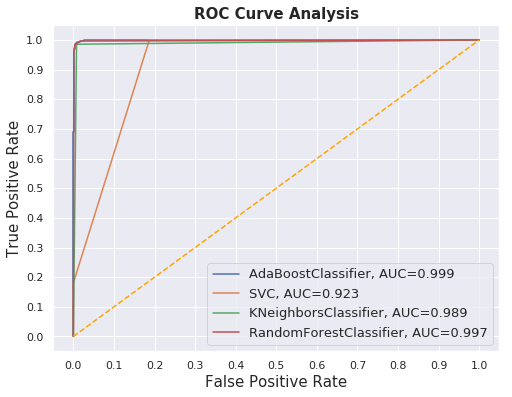

In [23]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_two, y_train_two)
    yproba = model.predict_proba(X_validation)[::,1]
    
    fpr, tpr, _ = roc_curve(y_validation,  yproba)
    auc = roc_auc_score(y_validation, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### 10. Train the method that gives the most accurate predictions so far (i.e. the highest overall accuracy) on the original train set after applying the best feature selection and normalization strategy and compute predictions on the samples of the test set(s) for which the true labels are available. Report the same accuracy measures as in step 5.

In [24]:
abc = AdaBoostClassifier(n_estimators=200, random_state=42)
dump_metrics(normalized_x_train, y_train, "Ada Boost", abc)

Ada Boost Accuracy Score: 0.992631204471
Ada Boost F-Measure: 0.982717263398
Ada Boost Sensitivity: 0.985844370418
Ada Boost Precision: 0.979829325551
Ada Boost Area Under ROC Curve: 0.990190002182
Ada Boost MCC: 0.978117303856



0.9926312044707059

### 11. Do literature review and find publications on the same topic. Which methods performed the best? Compare them with the methods you developed in this project. Can you improve your methods using the techniques implemented in the literature? Suggest ideas for improvement.